In [1]:
!pip install pandas numpy matplotlib seaborn nltk textblob wordcloud ipywidgets plotly scikit-learn

In [4]:
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import ipywidgets as widgets
from collections import Counter
import seaborn as sns
from textblob import TextBlob

# Download required NLTK resources at the beginning
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.corpus import stopwords
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    model_loaded = True
except Exception as e:
    print(f"Error loading NLTK resources: {e}")
    model_loaded = False

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

# Function to analyze sentiment
def analyze_sentiment(text):
    results = {}
    
    # Clean text
    clean_text = preprocess_text(text)
    
    # 1. Use pre-trained model if available
    if model_loaded:
        sia = SentimentIntensityAnalyzer()
        sentiment_scores = sia.polarity_scores(text)
        
        # Determine overall sentiment
        compound = sentiment_scores['compound']
        
        if compound >= 0.05:
            results['overall'] = 'Positive'
        elif compound <= -0.05:
            results['overall'] = 'Negative'
        else:
            results['overall'] = 'Neutral'
            
        results['scores'] = sentiment_scores
    
    # 2. Use TextBlob as a backup or additional method
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    results['textblob'] = {
        'polarity': polarity,
        'subjectivity': subjectivity
    }
    
    # 3. Analysis by sentences
    sentences = sent_tokenize(text)
    sentence_analysis = []
    
    # Analyze each sentence
    for sentence in sentences:
        if model_loaded:
            sentence_scores = sia.polarity_scores(sentence)
            sentence_compound = sentence_scores['compound']
            
            if sentence_compound >= 0.05:
                sentiment = 'Positive'
            elif sentence_compound <= -0.05:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'
        else:
            # Fallback to TextBlob
            sentence_blob = TextBlob(sentence)
            sentence_compound = sentence_blob.sentiment.polarity
            
            if sentence_compound >= 0.05:
                sentiment = 'Positive'
            elif sentence_compound <= -0.05:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'
        
        sentence_analysis.append({
            'sentence': sentence,
            'sentiment': sentiment,
            'score': sentence_compound
        })
    
    results['sentences'] = sentence_analysis
    
    # 4. Word frequency analysis
    words = word_tokenize(clean_text)
    word_freq = Counter(words)
    results['word_frequency'] = word_freq.most_common(10)
    
    return results, clean_text

# Function to display sentiment breakdown
def plot_sentiment_breakdown(results):
    if 'scores' in results:
        scores = results['scores']
        # Create a bar chart
        categories = ['Positive', 'Neutral', 'Negative']
        values = [scores['pos'], scores['neu'], scores['neg']]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(categories, values, color=['green', 'gray', 'red'])
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom')
        
        plt.title('Sentiment Breakdown')
        plt.ylabel('Score')
        plt.ylim(0, 1.0)
        plt.show()

# Function to display word frequency
def plot_word_frequency(word_freq):
    if not word_freq:
        return
    
    # Convert to lists for plotting
    words = [word for word, count in word_freq]
    counts = [count for word, count in word_freq]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(words, counts, color='skyblue')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom')
    
    plt.title('Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to display sentence sentiment
def plot_sentence_sentiment(sentence_analysis):
    if not sentence_analysis:
        return
    
    # Extract sentiment scores
    scores = [item['score'] for item in sentence_analysis]
    
    # Create x-axis labels (sentence numbers)
    x_labels = [f"S{i+1}" for i in range(len(scores))]
    
    # Define colors based on sentiment
    colors = ['green' if score > 0 else 'red' if score < 0 else 'gray' for score in scores]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_labels, scores, color=colors)
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title('Sentence-by-Sentence Sentiment Analysis')
    plt.xlabel('Sentences')
    plt.ylabel('Sentiment Score (Compound)')
    plt.ylim(-1.0, 1.0)
    plt.tight_layout()
    plt.show()
    
    # Print sentences with their sentiment
    print("Sentence breakdown:")
    for i, item in enumerate(sentence_analysis):
        sentiment_emoji = "😊" if item['sentiment'] == 'Positive' else "😞" if item['sentiment'] == 'Negative' else "😐"
        print(f"{i+1}. {sentiment_emoji} ({item['score']:.2f}): {item['sentence']}")

# Main function for analysis and visualization
def analyze_and_visualize(text):
    if not text or text.isspace():
        print("Please enter some text to analyze.")
        return
    
    # Get sentiment analysis results
    results, clean_text = analyze_sentiment(text)
    
    # Display overall result with emoji
    emoji = "😊" if results['overall'] == 'Positive' else "😞" if results['overall'] == 'Negative' else "😐"
    print(f"\n{emoji} Overall Sentiment: {results['overall']}")
    
    if 'scores' in results:
        print(f"Compound Score: {results['scores']['compound']:.2f}")
        print(f"Positive: {results['scores']['pos']:.2f}, Neutral: {results['scores']['neu']:.2f}, Negative: {results['scores']['neg']:.2f}")
    
    print(f"TextBlob Polarity: {results['textblob']['polarity']:.2f}")
    print(f"TextBlob Subjectivity: {results['textblob']['subjectivity']:.2f}")
    
    # Display charts
    print("\n--- Sentiment Breakdown ---")
    plot_sentiment_breakdown(results)
    
    print("\n--- Word Frequency Analysis ---")
    plot_word_frequency(results['word_frequency'])
    
    print("\n--- Sentence Analysis ---")
    plot_sentence_sentiment(results['sentences'])

# Create UI components
title = widgets.HTML(value="<h1>Sentiment Analysis Tool</h1>")

text_area = widgets.Textarea(
    value="I really enjoyed the movie. The actors were great, but the ending was a bit disappointing. Overall, I would recommend it.",
    placeholder='Enter text to analyze',
    description='Text:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='200px')
)

button = widgets.Button(
    description='Analyze Sentiment',
    button_style='primary',
    tooltip='Click to analyze',
    icon='check'
)

output = widgets.Output()

# Define button click event
def on_button_clicked(b):
    with output:
        clear_output()
        analyze_and_visualize(text_area.value)

button.on_click(on_button_clicked)

# Display UI
display(title)
display(text_area)
display(button)
display(output)

# Example run for initial display
print("Example: Click 'Analyze Sentiment' to analyze the sample text below or enter your own text.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


HTML(value='<h1>Sentiment Analysis Tool</h1>')

Textarea(value='I really enjoyed the movie. The actors were great, but the ending was a bit disappointing. Ove…

Button(button_style='primary', description='Analyze Sentiment', icon='check', style=ButtonStyle(), tooltip='Cl…

Output()

Example: Click 'Analyze Sentiment' to analyze the sample text below or enter your own text.


In [5]:
# IMPORTANT: RUN THIS CELL FIRST
# This cell ensures all required NLTK packages are downloaded

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download all the necessary NLTK data
try:
    print("Downloading required NLTK resources...")
    nltk.download('punkt')  # For tokenization
    nltk.download('stopwords')  # For stopwords
    nltk.download('wordnet')  # For lemmatization
    nltk.download('vader_lexicon')  # For sentiment analysis
    
    # For the specific punkt_tab error
    try:
        nltk.download('punkt_tab')  # This is what the error specifically mentions
    except:
        # If punkt_tab isn't a real package, we'll try downloading everything
        print("Note: punkt_tab might not be a standard package. Downloading all punkt-related packages...")
        nltk.download('all')  # This will download everything including punkt_tab if it exists
        
    print("Download complete! You can now run the sentiment analysis code.")
except Exception as e:
    print(f"Error during download: {e}")
    print("\nTROUBLESHOOTING STEPS:")
    print("1. Make sure you have internet connection")
    print("2. Try running the download manually in a Python console:")
    print("   import nltk")
    print("   nltk.download('punkt')")
    print("   nltk.download('stopwords')")
    print("   nltk.download('wordnet')")
    print("   nltk.download('vader_lexicon')")
    print("3. Check if you have write permission in the NLTK data directories")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


Download complete! You can now run the sentiment analysis code.


In [14]:
# MAIN SENTIMENT ANALYSIS CODE
# Only run this cell AFTER the download cell above has completed successfully

import re
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import ipywidgets as widgets
from collections import Counter
import seaborn as sns
from textblob import TextBlob

# Import NLTK components - we're trying a different approach to avoid the error
try:
    from nltk.corpus import stopwords
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    # Custom tokenization to avoid the punkt_tab error
    def safe_word_tokenize(text):
        """A safer word tokenize function that doesn't rely on punkt_tab"""
        # Simple whitespace tokenization as fallback
        return text.split()
    
    def safe_sent_tokenize(text):
        """A safer sentence tokenize function that doesn't rely on punkt_tab"""
        # Simple period/exclamation/question mark tokenization as fallback
        sentences = re.split(r'(?<=[.!?])\s+', text)
        return [s for s in sentences if s.strip()]
    
    # Try to import the standard tokenizers but use our safe versions as fallback
    try:
        from nltk.tokenize import word_tokenize as nltk_word_tokenize
        from nltk.tokenize import sent_tokenize as nltk_sent_tokenize
        word_tokenize = nltk_word_tokenize
        sent_tokenize = nltk_sent_tokenize
        print("Using NLTK tokenizers")
    except:
        print("Using fallback tokenizers")
        word_tokenize = safe_word_tokenize
        sent_tokenize = safe_sent_tokenize
    
    model_loaded = True
except Exception as e:
    print(f"Error loading NLTK resources: {e}")
    # Define fallback tokenizers
    def safe_word_tokenize(text):
        return text.split()
    
    def safe_sent_tokenize(text):
        sentences = re.split(r'(?<=[.!?])\s+', text)
        return [s for s in sentences if s.strip()]
    
    word_tokenize = safe_word_tokenize
    sent_tokenize = safe_sent_tokenize
    model_loaded = False

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords if available
    try:
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words]
    except:
        # If stopwords not available, just remove very common words
        common_words = {'the', 'a', 'an', 'and', 'or', 'but', 'is', 'are', 'was', 'were', 
                      'in', 'on', 'at', 'to', 'for', 'with', 'by', 'about', 'like', 'through'}
        filtered_tokens = [word for word in tokens if word not in common_words]
    
    return ' '.join(filtered_tokens)

# Function to analyze sentiment
def analyze_sentiment(text):
    results = {}
    
    # Clean text
    clean_text = preprocess_text(text)
    
    # 1. Use pre-trained model if available
    if model_loaded:
        try:
            sia = SentimentIntensityAnalyzer()
            sentiment_scores = sia.polarity_scores(text)
            
            # Determine overall sentiment
            compound = sentiment_scores['compound']
            
            if compound >= 0.05:
                results['overall'] = 'Positive'
            elif compound <= -0.05:
                results['overall'] = 'Negative'
            else:
                results['overall'] = 'Neutral'
                
            results['scores'] = sentiment_scores
        except Exception as e:
            print(f"Error with VADER: {e}")
            # We'll fall back to TextBlob below
    
    # 2. Use TextBlob as a backup or additional method
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # If VADER failed, use TextBlob for overall sentiment
    if 'overall' not in results:
        if polarity >= 0.05:
            results['overall'] = 'Positive'
        elif polarity <= -0.05:
            results['overall'] = 'Negative'
        else:
            results['overall'] = 'Neutral'
    
    results['textblob'] = {
        'polarity': polarity,
        'subjectivity': subjectivity
    }
    
    # 3. Analysis by sentences
    sentences = sent_tokenize(text)
    sentence_analysis = []
    
    # Analyze each sentence
    for sentence in sentences:
        if model_loaded:
            try:
                sentence_scores = sia.polarity_scores(sentence)
                sentence_compound = sentence_scores['compound']
                
                if sentence_compound >= 0.05:
                    sentiment = 'Positive'
                elif sentence_compound <= -0.05:
                    sentiment = 'Negative'
                else:
                    sentiment = 'Neutral'
            except:
                # Fallback to TextBlob
                sentence_blob = TextBlob(sentence)
                sentence_compound = sentence_blob.sentiment.polarity
                
                if sentence_compound >= 0.05:
                    sentiment = 'Positive'
                elif sentence_compound <= -0.05:
                    sentiment = 'Negative'
                else:
                    sentiment = 'Neutral'
        else:
            # Fallback to TextBlob
            sentence_blob = TextBlob(sentence)
            sentence_compound = sentence_blob.sentiment.polarity
            
            if sentence_compound >= 0.05:
                sentiment = 'Positive'
            elif sentence_compound <= -0.05:
                sentiment = 'Negative'
            else:
                sentiment = 'Neutral'
        
        sentence_analysis.append({
            'sentence': sentence,
            'sentiment': sentiment,
            'score': sentence_compound
        })
    
    results['sentences'] = sentence_analysis
    
    # 4. Word frequency analysis
    words = word_tokenize(clean_text)
    word_freq = Counter(words)
    results['word_frequency'] = word_freq.most_common(10)
    
    return results, clean_text

# Function to display sentiment breakdown
def plot_sentiment_breakdown(results):
    if 'scores' in results:
        scores = results['scores']
        # Create a bar chart
        categories = ['Positive', 'Neutral', 'Negative']
        values = [scores['pos'], scores['neu'], scores['neg']]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(categories, values, color=['green', 'gray', 'red'])
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom')
        
        plt.title('Sentiment Breakdown')
        plt.ylabel('Score')
        plt.ylim(0, 1.0)
        plt.show()
    else:
        # TextBlob fallback visualization
        tb = results['textblob']
        plt.figure(figsize=(8, 4))
        plt.bar(['Polarity', 'Subjectivity'], [tb['polarity'], tb['subjectivity']], 
                color=['blue', 'orange'])
        plt.title('TextBlob Sentiment Analysis')
        plt.ylim(-1, 1)
        plt.show()

# Function to display word frequency
def plot_word_frequency(word_freq):
    if not word_freq:
        return
    
    # Convert to lists for plotting
    words = [word for word, count in word_freq]
    counts = [count for word, count in word_freq]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(words, counts, color='skyblue')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom')
    
    plt.title('Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to display sentence sentiment
def plot_sentence_sentiment(sentence_analysis):
    if not sentence_analysis:
        return
    
    # Extract sentiment scores
    scores = [item['score'] for item in sentence_analysis]
    
    # Create x-axis labels (sentence numbers)
    x_labels = [f"S{i+1}" for i in range(len(scores))]
    
    # Define colors based on sentiment
    colors = ['green' if score > 0 else 'red' if score < 0 else 'gray' for score in scores]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(x_labels, scores, color=colors)
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title('Sentence-by-Sentence Sentiment Analysis')
    plt.xlabel('Sentences')
    plt.ylabel('Sentiment Score (Compound)')
    plt.ylim(-1.0, 1.0)
    plt.tight_layout()
    plt.show()
    
    # Print sentences with their sentiment
    print("Sentence breakdown:")
    for i, item in enumerate(sentence_analysis):
        sentiment_emoji = "😊" if item['sentiment'] == 'Positive' else "😞" if item['sentiment'] == 'Negative' else "😐"
        print(f"{i+1}. {sentiment_emoji} ({item['score']:.2f}): {item['sentence']}")

# Main function for analysis and visualization
def analyze_and_visualize(text):
    if not text or text.isspace():
        print("Please enter some text to analyze.")
        return
    
    # Get sentiment analysis results
    results, clean_text = analyze_sentiment(text)
    
    # Display overall result with emoji
    emoji = "😊" if results['overall'] == 'Positive' else "😞" if results['overall'] == 'Negative' else "😐"
    print(f"\n{emoji} Overall Sentiment: {results['overall']}")
    
    if 'scores' in results:
        print(f"Compound Score: {results['scores']['compound']:.2f}")
        print(f"Positive: {results['scores']['pos']:.2f}, Neutral: {results['scores']['neu']:.2f}, Negative: {results['scores']['neg']:.2f}")
    
    print(f"TextBlob Polarity: {results['textblob']['polarity']:.2f}")
    print(f"TextBlob Subjectivity: {results['textblob']['subjectivity']:.2f}")
    
    # Display charts
    print("\n--- Sentiment Breakdown ---")
    plot_sentiment_breakdown(results)
    
    print("\n--- Word Frequency Analysis ---")
    plot_word_frequency(results['word_frequency'])
    
    print("\n--- Sentence Analysis ---")
    plot_sentence_sentiment(results['sentences'])

# Create UI components
title = widgets.HTML(value="<h1>Sentiment Analysis Tool</h1>")

text_area = widgets.Textarea(
    value="I really enjoyed the movie. The actors were great, but the ending was a bit disappointing. Overall, I would recommend it.",
    placeholder='Enter text to analyze',
    description='Text:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='200px')
)

button = widgets.Button(
    description='Analyze Sentiment',
    button_style='primary',
    tooltip='Click to analyze',
    icon='check'
)

output = widgets.Output()

# Define button click event
def on_button_clicked(b):
    with output:
        clear_output()
        analyze_and_visualize(text_area.value)

button.on_click(on_button_clicked)

# Display UI
display(title)
display(text_area)
display(button)
display(output)



Using NLTK tokenizers


HTML(value='<h1>Sentiment Analysis Tool</h1>')

Textarea(value='I really enjoyed the movie. The actors were great, but the ending was a bit disappointing. Ove…

Button(button_style='primary', description='Analyze Sentiment', icon='check', style=ButtonStyle(), tooltip='Cl…

Output()

In [15]:
import sqlite3
import datetime

# Connect to SQLite database (creates file if not exists)
conn = sqlite3.connect('sentiment_analysis.db')
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS sentiment_results (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    text TEXT NOT NULL,
    overall_sentiment TEXT,
    vader_compound REAL,
    vader_pos REAL,
    vader_neu REAL,
    vader_neg REAL,
    textblob_polarity REAL,
    textblob_subjectivity REAL,
    word_frequency TEXT,
    sentence_sentiment TEXT,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
)
''')
conn.commit()

# Function to save a record into database
def save_result_to_db(text, results):
    # Convert word_frequency and sentence_sentiment lists to strings for storage
    word_freq_str = ', '.join([f"{w}:{c}" for w, c in results['word_frequency']])
    sentence_sent_str = '; '.join([f"{s['sentiment']}({s['score']:.2f}):{s['sentence']}" for s in results['sentences']])
    
    cursor.execute('''
        INSERT INTO sentiment_results 
        (text, overall_sentiment, vader_compound, vader_pos, vader_neu, vader_neg, 
         textblob_polarity, textblob_subjectivity, word_frequency, sentence_sentiment)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        text,
        results.get('overall', ''),
        results.get('scores', {}).get('compound', None),
        results.get('scores', {}).get('pos', None),
        results.get('scores', {}).get('neu', None),
        results.get('scores', {}).get('neg', None),
        results['textblob']['polarity'],
        results['textblob']['subjectivity'],
        word_freq_str,
        sentence_sent_str
    ))
    conn.commit()
    print("Result saved to database.")

# Function to fetch all saved records
def fetch_all_records():
    cursor.execute("SELECT * FROM sentiment_results ORDER BY timestamp DESC")
    rows = cursor.fetchall()
    for row in rows:
        print(f"ID: {row[0]}, Timestamp: {row[-1]}")
        print(f"Text: {row[1]}")
        print(f"Overall Sentiment: {row[2]}")
        print(f"VADER Compound: {row[3]}, Pos: {row[4]}, Neu: {row[5]}, Neg: {row[6]}")
        print(f"TextBlob Polarity: {row[7]}, Subjectivity: {row[8]}")
        print(f"Top Words: {row[9]}")
        print(f"Sentence Sentiments: {row[10]}")
        print('-'*50)

# Optional: export database to CSV file
import csv
def export_to_csv(csv_filename="sentiment_data.csv"):
    cursor.execute("SELECT * FROM sentiment_results")
    rows = cursor.fetchall()
    with open(csv_filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        # Write headers
        writer.writerow([desc[0] for desc in cursor.description])
        # Write data
        writer.writerows(rows)
    print(f"Data exported to {csv_filename}")

# ======= INTEGRATE with your existing analyze_and_visualize function ========

def analyze_and_visualize_with_save(text):
    if not text or text.isspace():
        print("Please enter some text to analyze.")
        return
    
    # Run your existing sentiment analysis function
    results, clean_text = analyze_sentiment(text)
    
    # Save results to database
    save_result_to_db(text, results)
    
    # Print and plot results as before
    emoji = "😊" if results['overall'] == 'Positive' else "😞" if results['overall'] == 'Negative' else "😐"
    print(f"\n{emoji} Overall Sentiment: {results['overall']}")
    
    if 'scores' in results:
        print(f"Compound Score: {results['scores']['compound']:.2f}")
        print(f"Positive: {results['scores']['pos']:.2f}, Neutral: {results['scores']['neu']:.2f}, Negative: {results['scores']['neg']:.2f}")
    
    print(f"TextBlob Polarity: {results['textblob']['polarity']:.2f}")
    print(f"TextBlob Subjectivity: {results['textblob']['subjectivity']:.2f}")
    
    print("\n--- Sentiment Breakdown ---")
    plot_sentiment_breakdown(results)
    
    print("\n--- Word Frequency Analysis ---")
    plot_word_frequency(results['word_frequency'])
    
    print("\n--- Sentence Analysis ---")
    plot_sentence_sentiment(results['sentences'])

# Modify your button click to call this new function instead
def on_button_clicked(b):
    with output:
        clear_output()
        analyze_and_visualize_with_save(text_area.value)

button.on_click(on_button_clicked)

# Now the interface with save feature works — data will be saved after every analysis

# You can also run these commands separately:
# fetch_all_records()  # To print all saved data
# export_to_csv()      # To export saved data as CSV file


Result saved to database.

😊 Overall Sentiment: Positive
Compound Score: 0.90
Positive: 0.65, Neutral: 0.35, Negative: 0.00
TextBlob Polarity: 0.62
TextBlob Subjectivity: 0.50

--- Sentiment Breakdown ---


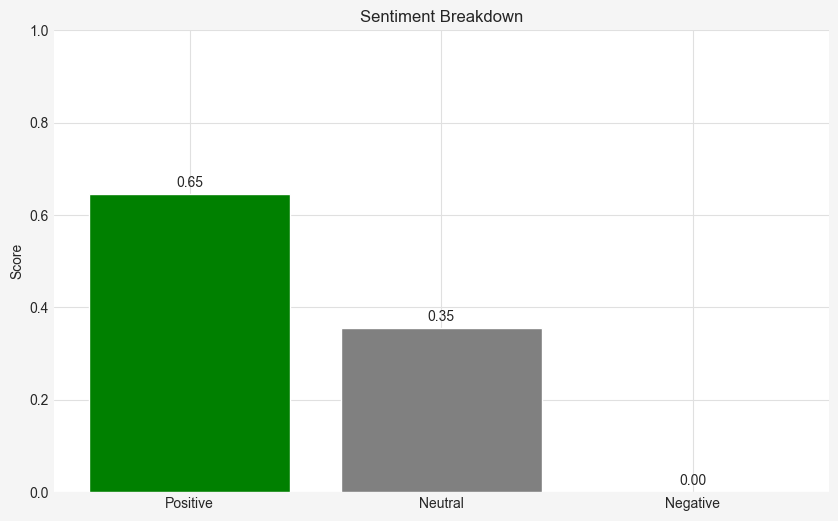


--- Word Frequency Analysis ---


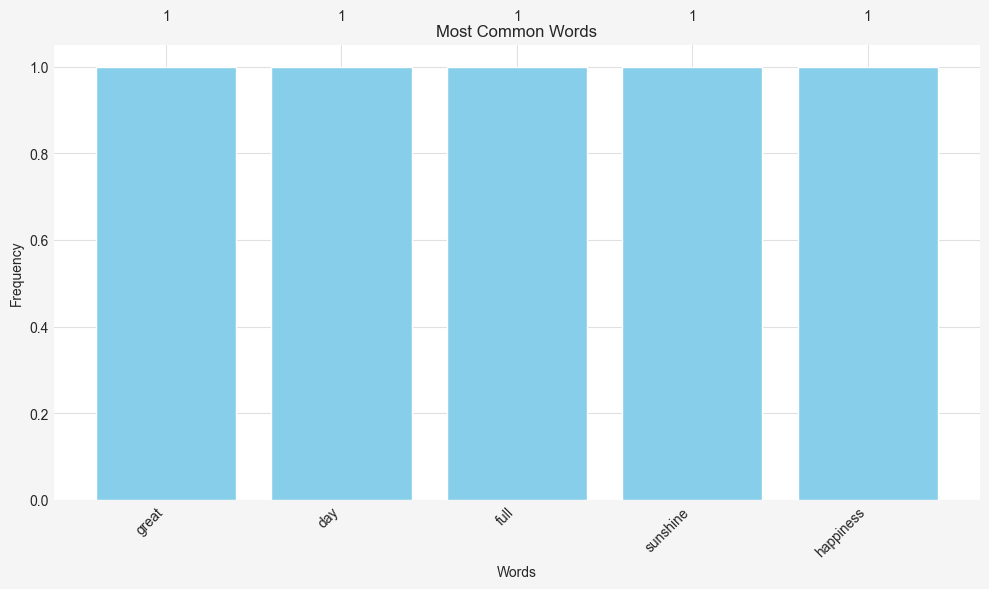


--- Sentence Analysis ---


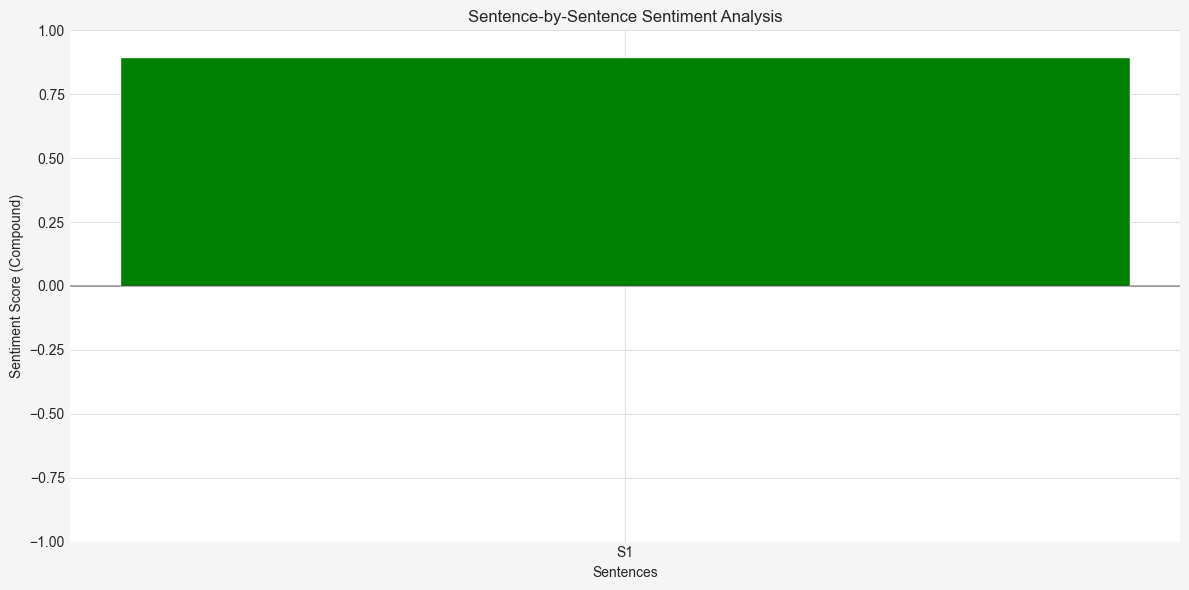

Sentence breakdown:
1. 😊 (0.90): This is a great day full of sunshine and happiness.


In [17]:
analyze_and_visualize_with_save("This is a great day full of sunshine and happiness.")


In [18]:
fetch_all_records()


ID: 1, Timestamp: 2025-05-16 09:03:44
Text: This is a great day full of sunshine and happiness.
Overall Sentiment: Positive
VADER Compound: 0.8979, Pos: 0.645, Neu: 0.355, Neg: 0.0
TextBlob Polarity: 0.6166666666666666, Subjectivity: 0.5
Top Words: great:1, day:1, full:1, sunshine:1, happiness:1
Sentence Sentiments: Positive(0.90):This is a great day full of sunshine and happiness.
--------------------------------------------------


In [19]:
!pip install nltk textblob matplotlib seaborn wordcloud ipywidgets


In [20]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Muthuchithra\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
import sqlite3
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import re
import nltk
import ipywidgets as widgets
from IPython.display import display, clear_output

# Setup SQLite
conn = sqlite3.connect('sentiment_records.db')
c = conn.cursor()
c.execute('''
CREATE TABLE IF NOT EXISTS analysis (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    input_text TEXT,
    sentiment TEXT,
    compound REAL,
    polarity REAL,
    subjectivity REAL
)
''')
conn.commit()

# Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Sentiment Analysis
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    blob = TextBlob(text)
    sentiment = "Positive" if scores['compound'] >= 0.05 else "Negative" if scores['compound'] <= -0.05 else "Neutral"
    clean_text = preprocess(text)
    word_freq = Counter(clean_text.split())
    sentence_scores = [(str(s), TextBlob(str(s)).sentiment.polarity) for s in blob.sentences]
    return {
        'overall': sentiment,
        'scores': scores,
        'textblob': {
            'polarity': blob.sentiment.polarity,
            'subjectivity': blob.sentiment.subjectivity
        },
        'word_frequency': word_freq.most_common(10),
        'sentences': sentence_scores,
        'clean_text': clean_text
    }

# Plot Functions
def plot_bar_chart(scores):
    fig, ax = plt.subplots()
    ax.bar(['Positive', 'Neutral', 'Negative'], [scores['pos'], scores['neu'], scores['neg']], color=['green', 'gray', 'red'])
    ax.set_title('VADER Sentiment Scores')
    plt.show()

def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud")
    plt.show()

def plot_sentence_scores(sentences):
    labels = [f"S{i+1}" for i in range(len(sentences))]
    scores = [s[1] for s in sentences]
    colors = ['green' if s > 0 else 'red' if s < 0 else 'gray' for s in scores]
    plt.bar(labels, scores, color=colors)
    plt.axhline(0, color='black')
    plt.title("Sentence-wise Polarity")
    plt.show()

# UI Widgets
text_input = widgets.Textarea(description="Input", layout=widgets.Layout(width='100%', height='150px'))
analyze_button = widgets.Button(description="Analyze", button_style='success')
view_db_button = widgets.Button(description="Show Saved Data", button_style='info')
output = widgets.Output()

# Handlers
def on_analyze_clicked(b):
    with output:
        clear_output()
        if not text_input.value.strip():
            print("Please enter some text.")
            return
        result = analyze_sentiment(text_input.value)

        # Save to DB
        c.execute("INSERT INTO analysis (input_text, sentiment, compound, polarity, subjectivity) VALUES (?, ?, ?, ?, ?)",
                  (text_input.value, result['overall'], result['scores']['compound'],
                   result['textblob']['polarity'], result['textblob']['subjectivity']))
        conn.commit()

        print(f"Overall Sentiment: {result['overall']}")
        print(f"VADER Compound: {result['scores']['compound']:.2f}")
        print(f"TextBlob Polarity: {result['textblob']['polarity']:.2f}")
        print(f"Subjectivity: {result['textblob']['subjectivity']:.2f}")
        
        print("\nTop Words:")
        for word, freq in result['word_frequency']:
            print(f"{word}: {freq}")
        
        print("\nSentence Sentiment:")
        for i, (sent, score) in enumerate(result['sentences']):
            status = "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"
            print(f"Sentence {i+1}: {status} ({score:.2f}) - {sent}")
        
        # Visuals
        plot_bar_chart(result['scores'])
        plot_sentence_scores(result['sentences'])
        plot_wordcloud(result['clean_text'])

def on_view_db_clicked(b):
    with output:
        clear_output()
        print("Saved Sentiment Records:\n")
        for row in c.execute("SELECT * FROM analysis ORDER BY id DESC"):
            print(f"[{row[0]}] {row[2]} | Compound: {row[3]:.2f} | Polarity: {row[4]:.2f} | Text: {row[1][:40]}...")

# Bind buttons
analyze_button.on_click(on_analyze_clicked)
view_db_button.on_click(on_view_db_clicked)

# Display
display(text_input, widgets.HBox([analyze_button, view_db_button]), output)


Textarea(value='', description='Input', layout=Layout(height='150px', width='100%'))

Output()

In [22]:
pip install voila


   ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.5 MB ? eta -:--:--
   ------ --------------------------------- 0.8/4.5 MB 2.8 MB/s eta 0:00:02
   ------------- -------------------------- 1.6/4.5 MB 3.2 MB/s eta 0:00:01
   -------------------- ------------------- 2.4/4.5 MB 3.2 MB/s eta 0:00:01
   --------------------------- ------------ 3.1/4.5 MB 3.5 MB/s eta 0:00:01
   ------------------------------------- -- 4.2/4.5 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 4.5/4.5 MB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3263141437.py, line 1)